In [1]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input, BatchNormalization
from keras.optimizers import Adam

from sklearn.decomposition import PCA

from tqdm import tqdm

#### Handle Import of Data

In [2]:
raw_results = pd.read_csv("data/actual.csv")
raw_results.sample(10)

,patient,cancer
7,8,ALL
37,38,AML
9,10,ALL
19,20,ALL
62,63,AML
48,49,ALL
59,60,AML
12,13,ALL
67,68,ALL
49,50,AML


In [3]:
raw_results.shape

(72, 2)

#### Calculate Class Weights and Convert to Numeric

In [4]:
from sklearn.utils.class_weight import compute_class_weight

y_train = raw_results.replace({"ALL":0, "AML":1})
weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train["cancer"]),
                               y=y_train["cancer"])
y_train["cancer"].value_counts()

0    47
1    25
Name: cancer, dtype: int64

In [5]:
weights

array([0.76595745, 1.44      ])

#### Load Other Data

In [6]:
independent_data = pd.read_csv("data/data_set_ALL_AML_independent.csv")
independent_data.sample(10)

,Gene Description,Gene Accession Number,39,call,40,call.1,42,call.2,47,call.3,...,65,call.29,66,call.30,63,call.31,64,call.32,62,call.33
2317,RFC2 Replication factor C (activator 1) 2; 40k...,M87338_at,-26,A,-96,A,44,A,203,A,...,-55,A,-19,A,32,A,-56,A,-76,A
1408,COL18A1 Collagen; type XVIII; alpha 1,L22548_at,-463,A,-282,A,116,A,-296,A,...,33,A,443,P,-131,A,-984,A,-340,A
6057,TKT Transketolase (Wernicke-Korsakoff syndrome),L12711_s_at,2158,P,686,P,2217,P,1611,P,...,3105,P,1601,P,6487,P,1886,P,4584,P
4398,SON SON DNA binding protein,X63753_at,219,P,486,P,344,P,353,P,...,138,P,228,P,488,P,759,P,535,P
5405,Repressor transcriptional factor (ZNF85) mRNA,U35376_at,-7,A,-17,A,-30,A,-18,A,...,-14,A,13,A,-41,A,-27,A,-4,A
3252,Aquaporin-5 (AQP5) gene,U46569_at,289,A,847,A,341,P,42,A,...,703,A,293,A,328,P,1035,A,722,P
5744,Antigen; Prostate Specific; Alt. Splice Form 2,HG2261-HT2351_s_at,45,A,-26,A,-16,A,37,A,...,62,A,30,A,115,A,208,A,122,A
1147,CKMT2 Creatine kinase; mitochondrial 2 (sarcom...,J05401_at,-43,A,-114,A,-87,A,-90,A,...,-116,A,-28,A,-44,A,-200,A,2,A
2185,MAJOR HISTOCOMPATIBILITY COMPLEX ENHANCER-BIND...,M69043_at,7285,P,2210,P,9757,P,1128,P,...,9837,P,4005,P,18579,P,2483,P,6443,P
2327,SERUM PROTEIN MSE55,M88338_at,441,A,96,A,319,A,-212,A,...,275,A,123,A,24,A,-219,A,222,A


In [7]:
train_data = pd.read_csv("data/data_set_ALL_AML_train.csv")
train_data.sample(10)

,Gene Description,Gene Accession Number,1,call,2,call.1,3,call.2,4,call.3,...,29,call.33,30,call.34,31,call.35,32,call.36,33,call.37
2769,Dehydroepiandrosterone sulfotransferase (STD) ...,U13061_rna1_at,-8,A,70,A,-13,A,-10,A,...,-22,A,-28,A,-31,A,44,A,15,A
2891,CEBPG CCAAT/enhancer binding protein (C/EBP); ...,U20240_at,85,A,576,P,59,A,94,A,...,163,P,235,P,-56,A,124,A,115,A
2850,Nuclear autoantigen GS2NA mRNA,U17989_at,122,A,104,P,98,A,112,P,...,43,A,79,P,34,P,90,P,199,P
6885,FLT3LG Fms-related tyrosine kinase 3 ligand,U03858_at,129,A,731,P,180,A,20,A,...,51,A,112,A,149,A,24,A,250,A
2321,TRANSCRIPTIONAL REGULATOR ISGF3 GAMMA SUBUNIT,M87503_at,1619,P,1522,P,1504,P,1212,P,...,431,A,1562,P,1089,P,1480,P,4394,P
812,Ornithine Aminotransferase-Like 3,HG1804-HT1829_at,1121,A,944,A,849,A,1253,A,...,470,A,904,A,854,A,804,A,879,A
4696,Putative chloride channel,X83378_at,48,A,400,A,234,A,228,A,...,251,A,436,A,473,A,553,A,527,A
2393,PLCB2 Phospholipase C; beta 2,M95678_at,1275,A,1876,P,864,A,917,A,...,1354,P,2445,P,1569,A,1942,P,4832,A
3903,HEM45 mRNA,U88964_at,3230,P,767,P,1457,P,1416,P,...,547,P,488,P,580,P,890,P,3131,P
3399,K-Cl cotransporter (hKCC1) mRNA,U55054_at,-53,A,-52,A,-305,A,6,A,...,21,A,-195,A,32,A,-5,A,104,A


#### Check for Missing Values

In [8]:
flag = False

for key, missing_count in dict(train_data.isnull().sum()).items():
    if missing_count > 0:
        print(key, "is missing:", missing_count, "values")
        flag = True
if not flag:
    print("No missing values found in train dataset")

No missing values found in train dataset


#### Remove Columns that are not used in PCA + Extra Metadata

In [9]:
if "Gene Description" in train_data.columns and "Gene Accession Number" in train_data.columns:
    train_data.drop(["Gene Description", "Gene Accession Number"], axis=1, inplace=True)

train_pre_pca = train_data[[col for col in train_data.columns if "call" not in col]]
train_pre_pca.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,35,36,37,38,28,29,30,31,32,33
1262,53,56,18,40,30,-238,-15,-37,-66,50,...,-151,-11,-50,-50,97,139,65,-6,38,19
3030,185,221,655,295,144,309,204,280,431,219,...,129,124,174,233,307,69,294,129,196,450
748,79,352,265,349,181,320,315,341,69,125,...,189,101,316,227,298,-1,222,241,223,260
5164,1248,542,1465,716,1147,743,712,935,1088,159,...,1110,337,192,750,-21,98,101,196,470,295
2269,24,76,9,56,-14,33,53,11,26,-3,...,26,17,79,24,5,-18,14,28,13,-21
5271,184,126,108,94,38,122,75,52,98,13,...,62,-19,156,42,81,17,180,65,77,79
2931,107,65,15,90,202,-8,23,-8,303,62,...,36,99,75,16,175,47,77,119,84,197
6977,-1,-98,199,239,55,-55,199,-80,197,57,...,-55,184,-54,109,110,-25,-35,115,130,153
4515,336,343,596,287,207,309,366,427,284,136,...,259,461,216,140,443,146,415,477,517,576
2486,212,156,180,135,161,104,156,166,41,132,...,141,263,388,-14,155,37,234,213,103,322


#### Reindex and Rotate so Subjects Line up with their Data

In [10]:
train_columns_titles = map(str, np.arange(1,39))
train_pre_pca = train_pre_pca.reindex(columns=train_columns_titles)
train_pre_pca_rot = train_pre_pca.T
train_pre_pca_rot.head(10)

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
6,-138,-85,215,71,-272,-558,67,-186,87,193,...,115,1221,-76,172,-74,645,341,26,193,-53
7,-72,-144,238,55,-399,-551,131,-179,126,-20,...,30,819,-178,151,-18,1140,482,10,369,-42
8,-413,-260,7,-2,-541,-790,-275,-463,70,-169,...,289,629,-86,302,23,1799,446,59,781,20
9,5,-127,106,268,-210,-535,0,-174,24,506,...,356,980,6,177,-12,758,385,115,244,-39
10,-88,-105,42,219,-178,-246,328,-148,177,183,...,42,986,26,101,21,570,359,9,171,7


#### Check Distributions to Detemine if we use MinMaxScaling or StandardScaler (Check Original Data, not Rotated)

In [11]:
import random

random_features = map(str, random.sample(range(0, len(train_pre_pca.columns)), 10))
#sns.pairplot(train_pre_pca[random_features], diag_kind="kde");

#### Apply Standard Scaler

In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

train_pre_pca_rot = train_pre_pca_rot.astype(float, 64)

scaler = MinMaxScaler()
transform_data = scaler.fit_transform(train_pre_pca_rot)
train_pre_pca_scaled = pd.DataFrame(data=transform_data, columns=train_pre_pca_rot.columns)
train_pre_pca_scaled.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
35,0.533469,0.244300,0.774476,0.827103,0.677551,0.366929,0.577951,0.501139,0.550685,0.108247,...,0.625767,1.000000,0.618687,0.180650,0.146341,0.517925,0.281835,0.460606,0.077621,0.900000
8,0.975659,0.651466,0.722028,0.710280,0.675510,0.401575,0.533408,0.658314,0.290411,0.929124,...,1.000000,0.529041,0.464646,0.056604,0.609756,0.265566,0.322097,1.000000,0.076995,0.423077
22,0.815416,0.019544,0.517483,0.000000,0.457143,0.458268,0.379733,0.783599,0.539726,0.255155,...,0.303681,0.583625,0.803030,0.056202,0.548780,0.199057,0.276217,0.357576,0.076682,1.000000
31,0.713996,0.807818,0.472028,0.855140,0.720408,0.577953,0.498886,0.546697,0.000000,0.503866,...,0.975460,0.499650,0.411616,0.159374,0.670732,0.459906,0.227528,0.539394,0.093897,0.700000
7,0.127789,0.218241,0.548951,0.079439,0.000000,0.000000,0.227171,0.000000,0.416438,0.059278,...,0.794479,0.283415,0.232323,0.106784,0.823171,0.756604,0.379213,0.660606,0.245070,0.876923
13,0.736308,0.586319,0.330420,0.651869,0.844898,0.617323,0.256125,0.535308,0.123288,0.422680,...,0.726994,0.151155,0.580808,0.077479,0.658537,0.111321,0.213483,0.351515,0.051643,0.553846
10,0.630832,0.560261,0.412587,0.275701,0.771429,0.566929,0.644766,0.806378,0.378082,0.728093,...,0.475460,0.292512,0.530303,0.040546,0.189024,0.225000,0.156367,0.454545,0.036933,0.246154
33,0.924949,0.390879,0.449301,0.320093,0.351020,0.411024,0.548998,0.223235,0.643836,0.314433,...,0.705521,0.549335,0.310606,0.041349,0.335366,0.301415,0.483146,0.230303,0.105477,0.223077
36,0.914807,1.000000,0.753497,0.843458,0.295918,0.513386,0.287305,0.166287,0.221918,0.738402,...,0.355828,0.183345,0.368687,0.119631,0.896341,0.725472,0.246255,0.375758,1.000000,0.469231
19,1.000000,0.319218,0.674825,0.593458,0.569388,0.607874,0.896437,0.596811,0.241096,0.881443,...,0.598160,0.557033,0.171717,0.069450,0.371951,0.584906,0.200375,0.624242,0.171205,0.600000


#### Perform Exhaustive Search for PCA

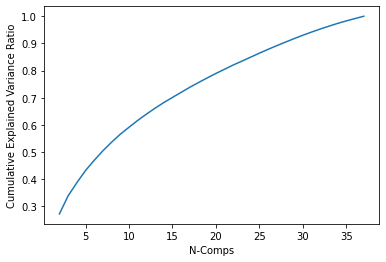

In [13]:
explained_var = []
n_comps = np.arange(2,38)

for n in n_comps:
    pca = PCA(n_components=n)
    principal_comps = pca.fit_transform(train_pre_pca_scaled)
    explained_var_value = np.cumsum(pca.explained_variance_ratio_)
    explained_var.append(explained_var_value[-1])
    
plt.plot(n_comps, explained_var)
plt.xlabel("N-Comps")
plt.ylabel("Cumulative Explained Variance Ratio");

#### We Select N-Comp = 20 as that Appears to be the Elbow Point for Roughly 90%, but plot only the first 2 Components

In [14]:
pca = PCA(n_components=34)
principal_components = pca.fit_transform(train_pre_pca_scaled)
train_pca = pd.DataFrame(data=principal_components)
train_pca.head(10)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,4.335955,1.873971,-4.492073,0.773770,-2.641525,4.426485,-1.742736,1.060366,-1.985917,2.537553,...,-3.808656,-1.267276,1.592440,-2.155034,1.507355,2.538646,0.545313,0.949153,1.183215,0.717715
1,-1.888290,2.243604,2.894183,1.310716,3.339522,-4.195679,0.379701,1.530271,0.615044,2.551174,...,-3.610300,-2.110314,5.401324,2.236673,3.129337,-1.052334,-4.132514,0.028127,0.163097,-0.103977
2,12.031244,3.846473,-6.740047,9.491940,-0.144719,-1.574215,-5.980327,3.808565,1.018972,0.438956,...,0.150408,0.616999,-0.195955,0.292101,-0.390007,1.498904,-0.860571,0.998343,-0.215251,-0.995323
3,3.429125,-1.189050,-5.278071,0.613200,0.322281,3.302466,7.713025,-0.653048,-2.128099,-4.104544,...,5.358893,-3.884200,2.303694,0.739769,4.377079,-2.296540,0.798097,1.802060,0.257376,0.646770
4,-8.867465,7.034777,1.061889,0.976604,0.632451,2.662190,1.001255,-0.258231,-1.865961,-0.411062,...,0.203232,1.291862,-0.745854,-0.750269,0.448097,3.040338,-0.642195,-2.426601,0.901842,0.264466
5,-1.661166,-4.579415,-5.306722,5.439508,3.866573,-2.165242,2.868586,-0.401125,-1.577875,1.071471,...,-3.330021,-2.678619,-5.163782,-4.761603,-1.404756,-4.218439,-1.402960,-0.163275,-0.969955,1.080265
6,5.432552,-3.372218,-5.906039,0.346285,-0.451822,3.828054,5.621128,-0.365142,-1.941039,-4.238888,...,-3.751737,3.594710,-1.695499,0.499329,-0.457545,1.932548,0.493335,0.561677,-1.385712,0.102727
7,12.894454,-4.096504,-7.825406,-2.412735,-6.973491,0.238753,4.744957,-4.555734,7.423349,9.688407,...,-0.941088,-0.097613,-0.076052,0.042662,0.155437,0.918782,-0.058730,-0.191701,0.141958,0.396080
8,4.780719,7.528113,-2.088588,11.627911,3.432257,-4.151326,-1.575719,-0.169591,0.988938,-0.303066,...,3.019305,0.676680,-0.305453,1.551998,0.393351,-1.154409,-2.807100,0.519200,0.886927,-0.602634
9,-5.175140,-2.124071,-0.851304,1.345526,2.796876,-2.467357,-2.546946,2.290942,-1.540921,0.211662,...,-1.073122,-1.575250,0.378457,-0.078030,0.323777,0.712502,3.793726,-1.254741,7.209347,5.288463


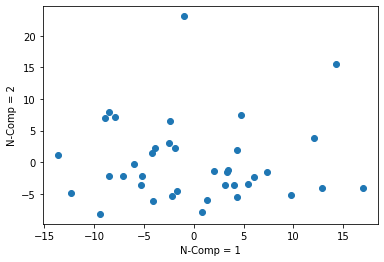

In [15]:
plt.scatter(train_pca[0], train_pca[1])
plt.xlabel("N-Comp = 1")
plt.ylabel("N-Comp = 2");

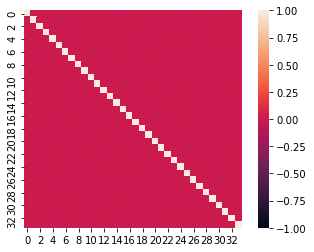

In [16]:
sns.heatmap(train_pca.corr(), vmin=-1, vmax=1, square=True);

#### Apply Same Preprocessing Pipeline to Testing Data

In [17]:
if "Gene Description" in independent_data.columns and "Gene Accession Number" in independent_data.columns:
    independent_data.drop(["Gene Description", "Gene Accession Number"], axis=1, inplace=True)

test_pre_pca = independent_data[[col for col in independent_data.columns if "call" not in col]]
test_pre_pca.sample(10)

,39,40,42,47,48,49,41,43,44,45,...,54,57,58,60,61,65,66,63,64,62
6977,-33,-199,80,14,132,-116,-82,-96,-180,-365,...,-169,86,52,12,34,-3,-89,97,-92,-78
1484,57,-32,55,-33,17,34,14,0,69,81,...,87,39,-12,1,4,-89,-49,51,8,50
5777,-79,-109,45,46,30,-37,29,149,290,204,...,202,-112,52,28,-34,-26,13,185,32,164
6075,251,187,211,81,200,173,106,192,109,76,...,294,188,318,107,322,19,21,429,365,326
5137,3024,3387,2625,3034,6920,2555,3605,1737,3277,2850,...,5275,2724,2151,2834,2715,3246,2316,5584,8385,5439
5873,217,244,29,-18,78,222,-48,24,44,68,...,20,174,49,52,69,-21,-6,34,252,74
4345,1018,2124,1088,1647,3483,961,1549,1225,1094,1006,...,1658,949,760,1181,938,1673,1569,2806,731,2020
915,-33,98,-96,142,21,-42,-20,283,54,296,...,-42,174,52,-23,-17,26,41,88,-140,85
2405,53,420,562,195,103,111,192,76,120,591,...,-43,-25,18,49,60,39,173,32,352,451
3310,680,421,264,292,544,272,344,605,197,249,...,548,277,571,123,166,313,306,624,539,303


In [18]:
test_columns_titles = map(str, np.arange(39,73))
test_pre_pca = test_pre_pca.reindex(columns=test_columns_titles)
test_pre_pca_rot = test_pre_pca.T
test_pre_pca_rot.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
50,-118,-142,212,314,-401,-452,-336,-310,177,-131,...,134,690,-8,331,-62,882,264,73,315,7
55,-34,-144,-17,152,-174,-289,361,-89,87,104,...,87,753,-22,259,47,806,342,14,239,24
71,-59,-114,23,146,-171,-227,-73,-126,-6,149,...,214,760,-38,201,-55,348,208,0,74,-12
65,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,92,532,-34,239,-78,707,354,-22,260,5
70,-55,-44,12,129,-108,-301,-222,-133,136,320,...,131,318,35,241,-66,320,174,-4,176,40
69,-79,-118,-30,68,-110,-264,-28,-61,40,-217,...,409,617,-34,738,11,742,234,72,109,-30
61,-47,-442,-21,396,-351,-394,236,-39,95,203,...,342,970,-106,240,-86,1111,459,-8,73,-41
51,-112,-185,24,170,-197,-400,-215,-227,100,307,...,146,621,34,295,4,1110,174,8,533,-4
39,-342,-200,41,328,-224,-427,-656,-292,137,-144,...,277,1023,67,214,-135,1074,475,48,168,-70
48,-130,-177,-28,266,-170,-326,-222,-93,10,159,...,233,643,51,450,-46,612,370,29,333,-19


In [19]:
test_pre_pca_rot = test_pre_pca_rot.astype(float, 64)

scaler = MinMaxScaler()
transform_data = scaler.fit_transform(test_pre_pca_rot)
test_pre_pca_scaled = pd.DataFrame(data=transform_data, columns=test_pre_pca_rot.columns)
test_pre_pca_scaled.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
7,0.668224,0.942085,0.627424,0.398104,0.645609,0.909884,0.534058,0.884354,0.385417,0.317979,...,0.341826,0.368035,0.690867,0.000000,0.891386,0.296336,0.226793,0.927835,0.064247,0.477612
24,0.422897,0.610039,0.504155,0.324645,0.559322,0.311047,0.524327,0.251701,0.830729,0.238484,...,0.399151,0.401760,0.627635,0.520473,0.677903,0.394052,0.513713,0.704467,0.136341,0.768657
32,0.661215,0.805019,0.599723,0.324645,0.560863,0.847384,0.552376,0.739229,0.369792,0.458395,...,0.577495,0.490469,0.601874,0.204732,0.617978,0.149230,0.263713,0.711340,0.069642,0.664179
14,0.327103,0.496139,0.649584,0.710900,0.121726,0.332849,0.503148,0.247166,1.000000,0.342496,...,0.558386,0.277859,0.566745,0.378526,0.426966,0.242167,0.652954,0.621993,0.135360,0.444030
6,0.362150,0.664093,1.000000,0.315166,1.000000,0.962209,0.488838,0.723356,0.416667,0.419762,...,0.201699,0.024927,0.257611,0.033667,0.269663,0.125863,0.043249,0.000000,0.088279,0.000000
12,0.537383,0.667954,0.601108,0.381517,0.520801,0.595930,0.471093,0.510204,0.645833,0.575780,...,0.433121,0.388563,0.770492,0.290264,0.838951,0.553903,0.227848,0.738832,0.294752,0.694030
17,0.577103,0.797297,0.649584,0.618483,0.471495,0.620640,0.692616,0.600907,0.867188,0.464339,...,0.560510,0.446481,0.548009,0.368517,0.430712,0.531599,0.478903,0.563574,0.377636,0.776119
1,0.595794,0.546332,0.930748,0.677725,0.476117,0.460756,0.804236,0.000000,0.890625,0.468053,...,0.299363,0.321114,0.000000,0.342129,0.573034,0.000000,0.321730,0.597938,0.017165,0.630597
27,0.663551,0.606178,0.655125,0.203791,0.530046,0.843023,0.544934,0.680272,0.369792,0.162704,...,0.256900,0.151026,0.775176,0.347589,0.831461,0.189060,0.087553,0.711340,0.904855,0.526119
9,0.495327,0.683398,0.529086,0.609005,0.562404,0.703488,0.467086,0.814059,0.411458,0.465825,...,0.617834,0.404692,0.810304,0.431301,0.651685,0.289432,0.434599,0.810997,0.196665,0.638060


In [20]:
pca = PCA(n_components=34)
principal_components = pca.fit_transform(test_pre_pca_scaled)
test_pca = pd.DataFrame(data=principal_components)
test_pca.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
13,-5.721393,-4.197198,-9.023547,-3.299440,3.298347,2.610700,1.442410,-3.874004,1.159793,-1.825093,...,0.020685,-0.739558,-0.821737,-1.110994,0.049057,-0.872096,0.675645,0.474183,-0.224158,4.190105e-15
21,-5.135768,-4.242712,-2.889219,-0.701036,3.148264,-2.835518,1.778302,3.190376,-2.364879,-1.337486,...,-0.203441,2.054123,-2.729568,-2.267742,-0.183590,-1.774402,1.036970,0.023772,-0.305222,4.190105e-15
19,6.975931,-9.203869,5.677975,-2.871945,5.697943,-7.915247,0.928849,-6.799666,-4.693573,8.220229,...,-0.789028,0.521580,-0.729057,0.138401,-0.723908,0.278871,0.062077,-0.184262,0.356210,4.190105e-15
11,5.129641,-1.044340,-3.344813,-9.088923,-2.460435,5.708938,-2.536739,3.370207,-2.222703,1.152868,...,-4.992318,-2.329577,1.648562,0.454288,-0.769904,-0.645783,0.084332,0.636798,-0.263052,4.190105e-15
12,2.853368,-3.375199,-1.887799,-6.565159,-4.750636,3.491586,0.463472,3.196573,-2.395875,0.789375,...,6.788070,2.566395,-2.906756,0.820910,0.932365,0.584982,1.047732,0.290399,-0.328560,4.190105e-15
0,4.005108,-4.294122,9.161792,1.870622,-2.894333,-1.923904,-6.469881,-3.013206,5.652555,-0.766979,...,0.454061,2.064829,0.858567,-0.250456,0.429560,0.180263,0.614143,-0.305847,0.130088,4.190105e-15
1,4.749001,-4.285188,-4.724698,7.402139,-4.355117,3.580208,5.466389,4.150971,8.712787,6.987117,...,0.125531,0.010334,0.925082,0.251928,0.393382,0.244727,0.430205,0.216766,0.042827,4.190105e-15
24,11.305305,2.299512,-6.343848,-4.558499,7.935639,3.447060,-0.337931,-4.454224,2.441603,2.721975,...,3.728245,1.613591,-0.232453,-0.688287,0.238237,0.887995,0.111982,0.189202,0.300076,4.190105e-15
15,-0.124035,1.838927,-3.059309,-0.450235,9.961160,-4.627037,-7.153476,8.420467,-0.477436,0.572625,...,0.183403,0.129304,0.050185,-0.811926,-0.853441,0.576593,-0.553862,0.062988,0.170952,4.190105e-15
28,-4.258818,2.718353,-0.766298,-4.233406,-5.437344,-3.228625,1.041796,-2.257400,1.372244,-3.268659,...,0.497611,4.521725,2.470139,-3.135285,4.104652,5.451262,-0.709934,0.319839,-0.808400,4.190105e-15


#### Define a Neural Network for Classifying

In [21]:
import keras

X_input = Input(shape=train_pca.shape[1])
X = Dense(16, activation=keras.layers.LeakyReLU(alpha=0.3))(X_input)
X = Dropout(0.1)(X)

X = Dense(16, activation=keras.layers.LeakyReLU(alpha=0.3))(X)
X = Dropout(0.1)(X)

X = Dense(16, activation=keras.layers.LeakyReLU(alpha=0.3))(X)
X = Dropout(0.1)(X)

X = Dense(1, activation="sigmoid")(X)

model = Model(inputs=X_input, outputs=X)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                560       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

#### Train Neural Network

In [22]:
import warnings

warnings.filterwarnings("ignore")

In [23]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath="modern_model.h5", monitor="loss")
]

In [24]:
weights_data = {0:weights[0], 1:weights[1]}

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4, decay=1e-4), metrics=["accuracy"])
history = model.fit(train_pca, y_train["cancer"][0:38], batch_size=4, epochs=10, shuffle=True,
                    class_weight=weights_data, callbacks=callbacks, 
                    validation_data=(test_pca, y_train["cancer"][38:73]))

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
10/10 [==============================] - 9s 44ms/step - loss: 0.7850 - accuracy: 0.5770 - val_loss: 0.6764 - val_accuracy: 0.6765
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 1.0008 - accuracy: 0.5408 - val_loss: 0.6756 - val_accuracy: 0.6471
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.9017 - accuracy: 0.5330 - val_loss: 0.6745 - val_accuracy: 0.6471
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 1.2847 - accuracy: 0.4669 - val_loss: 0.6739 - val_accuracy: 0.6471
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.8537 - accuracy: 0.4598 - val_loss: 0.6736 - val_accuracy: 0.6471
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.8485 - accuracy: 0.5768 - val_loss: 0.6741 - val_accuracy: 0.6471
Epoch 7/10
10/10 [===

#### Evaluate

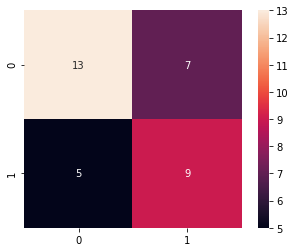

In [25]:
from sklearn.metrics import confusion_matrix

model  = tf.keras.models.load_model("modern_model.h5")
preds  = model.predict(test_pca)

y_pred = []

for pred in preds:
    if pred >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

sns.heatmap(confusion_matrix(y_train["cancer"][38:73], y_pred), annot=True, square=True);

#### Define Second Architecture

In [26]:
X_input = Input(shape=train_pca.shape[1])

X = Dense(16, activation="sigmoid")(X_input)
X = Dropout(0.1)(X)

X = Dense(24, activation="sigmoid")(X)
X = Dropout(0.1)(X)

X = Dense(16, activation="sigmoid")(X)
X = Dropout(0.1)(X)

X = Dense(2, activation="softmax")(X)

model = Model(inputs=X_input, outputs=X)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 34)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                560       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_4 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                400       
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0   

In [27]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath="traditional_model.h5", monitor="loss")
]

In [28]:
weights_data = {0:weights[0], 1:weights[1]}

model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4, decay=1e-4), metrics=["accuracy"])
history = model.fit(train_pca, pd.get_dummies(y_train["cancer"][0:38]), batch_size=4, epochs=10, shuffle=True,
                    class_weight=weights_data, callbacks=callbacks,
                    validation_data=(test_pca, pd.get_dummies(y_train["cancer"][38:73])))

Epoch 1/10
10/10 [==============================] - 1s 27ms/step - loss: 0.5923 - accuracy: 0.7494 - val_loss: 0.6872 - val_accuracy: 0.5882
Epoch 2/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6792 - accuracy: 0.4897 - val_loss: 0.6873 - val_accuracy: 0.5882
Epoch 3/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6346 - accuracy: 0.6678 - val_loss: 0.6873 - val_accuracy: 0.5882
Epoch 4/10
10/10 [==============================] - 0s 2ms/step - loss: 0.5890 - accuracy: 0.7102 - val_loss: 0.6872 - val_accuracy: 0.5882
Epoch 5/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6327 - accuracy: 0.7257 - val_loss: 0.6871 - val_accuracy: 0.5882
Epoch 6/10
10/10 [==============================] - 0s 2ms/step - loss: 0.7797 - accuracy: 0.5417 - val_loss: 0.6871 - val_accuracy: 0.5882
Epoch 7/10
10/10 [==============================] - 0s 2ms/step - loss: 0.6723 - accuracy: 0.5439 - val_loss: 0.6868 - val_accuracy: 0.5882
Epoch 8/10
10/10 [=

#### Evaluate

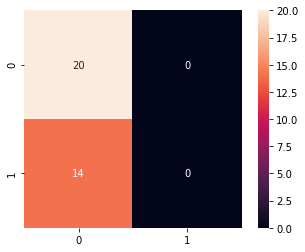

In [29]:
from sklearn.metrics import confusion_matrix

model  = tf.keras.models.load_model("traditional_model.h5")

preds  = model.predict(test_pca)

y_pred = np.argmax(preds, axis=1)

sns.heatmap(confusion_matrix(y_train["cancer"][38:73], y_pred), annot=True, square=True);

#### Check Without PCA

In [30]:
import keras

X_input = Input(shape=train_pre_pca_scaled.shape[1])
X = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.3))(X_input)
X = Dropout(0.1)(X)

X = Dense(512, activation=keras.layers.LeakyReLU(alpha=0.3))(X)
X = Dropout(0.1)(X)

X = Dense(256, activation=keras.layers.LeakyReLU(alpha=0.3))(X)
X = Dropout(0.1)(X)

X = Dense(1, activation="sigmoid")(X)

model = Model(inputs=X_input, outputs=X)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 7129)]            0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               1825280   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0   

In [31]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath="modern_model_no_pca.h5", monitor="val_loss")
]

In [32]:
weights_data = {0:weights[0], 1:weights[1]}

model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4, decay=1e-4), metrics=["accuracy"])
history = model.fit(train_pre_pca_scaled, y_train["cancer"][0:38], batch_size=4, epochs=10, shuffle=True,
                    class_weight=weights_data, callbacks=callbacks, 
                    validation_data=(test_pre_pca_scaled, y_train["cancer"][38:73]))

Epoch 1/10
10/10 [==============================] - 1s 33ms/step - loss: 0.9259 - accuracy: 0.6509 - val_loss: 0.7122 - val_accuracy: 0.4118
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 0.6362 - accuracy: 0.5464 - val_loss: 0.5971 - val_accuracy: 0.5882
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.6444 - accuracy: 0.4487 - val_loss: 0.5268 - val_accuracy: 0.6765
Epoch 4/10
10/10 [==============================] - 0s 6ms/step - loss: 0.3964 - accuracy: 0.8448 - val_loss: 0.4392 - val_accuracy: 0.7941
Epoch 5/10
10/10 [==============================] - 0s 7ms/step - loss: 0.2043 - accuracy: 0.9621 - val_loss: 0.4231 - val_accuracy: 0.7941
Epoch 6/10
10/10 [==============================] - 0s 7ms/step - loss: 0.1593 - accuracy: 0.9536 - val_loss: 0.5205 - val_accuracy: 0.6765
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.0934 - accuracy: 1.0000 - val_loss: 0.4728 - val_accuracy: 0.7647
Epoch 8/10
10/10 [=

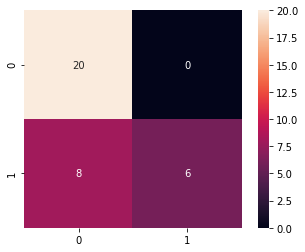

In [33]:
model  = tf.keras.models.load_model("modern_model_no_pca.h5")
preds  = model.predict(test_pre_pca_scaled)

y_pred = []

for pred in preds:
    if pred >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

sns.heatmap(confusion_matrix(y_train["cancer"][38:73], y_pred), annot=True, square=True);

#### Test Other Supervised Techniques

In [34]:
from sklearn.mixture import GaussianMixture

gmm_clf = GaussianMixture(n_components=2, random_state=42)
gmm_clf = gmm_clf.fit(train_pca)

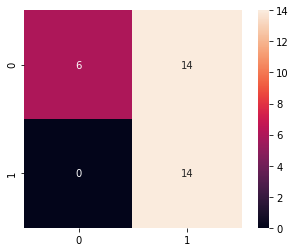

In [35]:
preds  = gmm_clf.predict(test_pca)

y_pred = preds

sns.heatmap(confusion_matrix(y_train["cancer"][38:73], y_pred), annot=True, square=True);

In [36]:
gmm_clf = GaussianMixture(n_components=2, random_state=42)
gmm_clf = gmm_clf.fit(train_pre_pca_scaled)

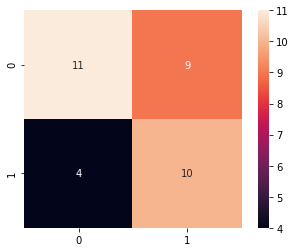

In [37]:
preds  = gmm_clf.predict(test_pre_pca_scaled)

y_pred = preds

sns.heatmap(confusion_matrix(y_train["cancer"][38:73], y_pred), annot=True, square=True);